# Fitting a hyperbola to the amplitude points

Fits a hyperbolic curve ```1 / x``` to the points exported by the [Audio Analyser Notebook](./audio-analyser.ipynb) to calculate the **Intensity** of the sound wave (```Power per Area``` (?)) and then the distance or the velocity of the passing vehicle.

In [4]:
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal

import plotting_util
from reportlab.lib import pagesizes
from reportlab.lib.units import mm
from reportlab.lib import pagesizes
A6_LS = pagesizes.landscape(pagesizes.A6)
PAGE_SMALL = (160*mm, 80*mm)


# Setup; basics

In [5]:
# Import serialized symmetrical list to file
def import_list_binary(filename:str):
    with open(filename + '.dat', 'rb') as fd:
        list = pickle.load(fd)
    return list

symm_array = import_list_binary("hyperbolic_raw_data")

# Curve fitting

Fit a curve using a recursive approach:

- The list created in the [Audio Analyser Notebook](./audio-analyser.ipynb) already has the highest point as list index 0
- A default ```1 / x``` curve is created, the distance along the y-axis between the points of the curve and the discrete measurement points are calculated
- For every iteration, the factor ```a``` of ```a / x``` is adjusted to decrease the overall distance between curve and discrete points &rarr; see quality function (*Gütefunktion*)
- The quality function squares each distance to prevent averaging of points above and below the curve (otherwise, )

The resulting curve represents the sound intensity over time.

Optimal a: 3248 ;	remaining distance: 2.2950E+14


C:\Users\Levin\AppData\Local\Temp\ipykernel_23968\1837358209.py:111: RuntimeWarning: divide by zero encountered in true_divide
  plotting_util.plot_graph("Approximated function", "y", t, symm_array, t, optimal_a / t, np.max(symm_array) * 1.2)


<Figure size 640x480 with 0 Axes>

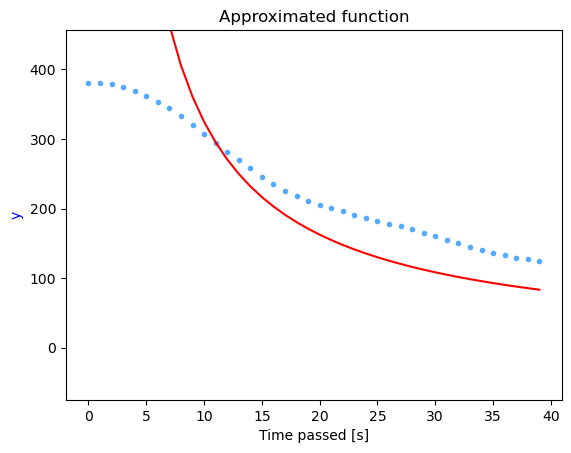

In [6]:

class Hyperbola:
    def __init__(self, a) -> None:
        self.a = a
    
    def set_a(self, new_a):
        self.a = new_a
    
    def y(self, x):
        return self.a / x


# test values
# t = 10.1234
# symm_array = [9999, t, t/2, t/3, t/4, t/5, t/6]

def quality_function(scaling_factor, algorithm: str) -> float:
    """
        Iterate over each point in the list, calculate its distance to the continuous curve; cumulate the distance
    """
    intensity_hyperbola = Hyperbola(scaling_factor)

    dist_sum = 0
    # start with idx 1 as 0 is at asymptote
    for x_counter in range(1, len(symm_array)):
        y_discrete = symm_array[x_counter]
        y_function = intensity_hyperbola.y(x_counter)
        dist = y_discrete - y_function
        dist = dist * dist # remove sign; increase weight of larger distances

        # decrease weight for points near the asymptote
        # TODO: use match-case (since Python 3.10)
        if(algorithm.lower() == "exp"):
            dist = dist * math.exp(x_counter)
        elif(algorithm.lower() == "square"):
            dist = dist * (x_counter ** 2)
        elif(algorithm.lower() == "cube"):
            dist = dist * (x_counter ** 3)
        
        # dist_sum += abs(dist)
        dist_sum += dist * dist
    
    return dist_sum

# Streckfaktor a annähern


def approximate_hyperbola_scaling_factor(precision_pow_10, max_pow_10, algorithm):
    return __approx_recursive__(0, max_pow_10, precision_pow_10, 1, algorithm)

def __approx_recursive__(current_approx, current_pow_10, precision, direction, algorithm) -> tuple[float, float]:
    """
        Recursively approximates the scaling factor for the hyperbola.

        For detailed information as well as an example see the image "recusive_approximation_of_a_number.png"

        current_approx: the current approximation
        current_pow_10: the current power of ten; when invoking from outside the recursion, the maximum power of ten
                max power of 10: the maximum power of ten to approximate with; this number is necessary to improve performance and to prevent infinite looping
        direction: whether to increase or decrease the current approximation by current_pow_10's (1: increase; -1: decrease)

        Returns: A tuple with (best approximation; quality of best approximation as returned by #quality_function)
    """
    
    magnitude_addend = 10 ** current_pow_10

    prev_prev_val = 0
    prev_val = 0
    this_val = current_approx

    dist_prev = 0
    dist_this = 0

    i_temp = 0
    while i_temp < 10:
        prev_prev_val = prev_val
        prev_val = this_val

        this_val = prev_val + magnitude_addend * direction # change value

        # perform checks
        dist_prev = quality_function(prev_val, algorithm)
        dist_this = quality_function(this_val, algorithm)
        if dist_this > dist_prev: # "über das Ziel hinausgeschossen"
            break

    if current_pow_10 == precision:
        # maximum precision reached
        return (prev_val, dist_prev)

    dist_prev_prev = quality_function(prev_prev_val, algorithm)

    comparison = dist_prev_prev < dist_this
    if direction < 0:
        # invert direction if direction was already inverted -> see detailed information
        comparison = not comparison

    if comparison:
        # invert direction of next lower magnitude approximation
        # -> it counts down from prev_val instead of counting up
        return __approx_recursive__(prev_val, current_pow_10 - 1, precision, -1, algorithm)
    else:
        return __approx_recursive__(prev_val, current_pow_10 - 1, precision, 1, algorithm)

weighted_approx_method = "square"
approx_result = approximate_hyperbola_scaling_factor(0, 4, weighted_approx_method)
optimal_a = approx_result[0]
dist_optimal_a = approx_result[1]

print(f"Optimal a: {optimal_a} ;\tremaining distance: {'%.4E' % Decimal(dist_optimal_a)}")

t = np.arange(len(symm_array))
plotting_util.plot_graph("Approximated function", "y", t, symm_array, t, optimal_a / t, np.max(symm_array) * 1.2)

compute_info_str = f"""
Used approximation function: \'{weighted_approx_method}\'
Optimal a = {optimal_a}
remaining distance (optimal a): {'%.4E' % Decimal(dist_optimal_a)}
"""
plotting_util.create_pdf_text_page(
    "summarized_plots/pdf/(b_x)compute_info", compute_info_str, page_size=PAGE_SMALL)
